In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Input
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, Flatten,MultiHeadAttention
import warnings
warnings.filterwarnings("ignore")
import cv2

#### Read image 256 x 256 x 3 RGB Image convert into patches 16 x 16 x 768

In [44]:
image = cv2.imread("C:\\ajay_ml\\VIT_Transformers\\img1.jpg")
image = cv2.resize(image,(256,256))
print("original image shape :{}".format(image.shape))
image = tf.expand_dims(image,axis=0)
patches = tf.image.extract_patches(images=image,sizes=[1,16,16,1],strides=[1,16,16,1],rates=[1,1,1,1],padding="VALID")
print("patches shape :{}".format(patches.shape))

original image shape :(256, 256, 3)
patches shape :(1, 16, 16, 768)


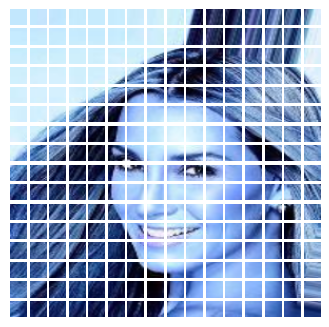

In [45]:
k=0
plt.figure(figsize=(4,4))
for i in range(16):
    for j in range(16):
        plt.subplot(16,16,k+1)
        plt.imshow(tf.reshape(patches[:,i,j,:],(16,16,3)))
        plt.axis("off")
        k += 1
plt.show()

In [46]:
patches=tf.reshape(patches,(patches.shape[0],patches.shape[1]*patches.shape[2],patches.shape[-1]))

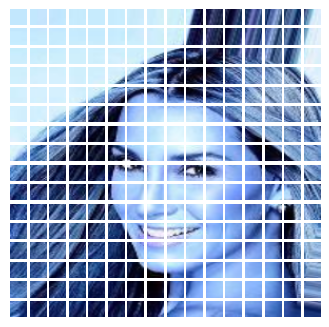

In [47]:
k=0
plt.figure(figsize=(4,4))
for i in range(256):
        plt.subplot(16,16,i+1)
        plt.imshow(tf.reshape(patches[:,i,:],(16,16,3)))
        plt.axis("off")
plt.show()

#### Data Preprocessing 

In [48]:
train_directory = "C:\\ajay_ml\\Human Emotions Detection\\train"
val_directory = "C:\\ajay_ml\\Human Emotions Detection\\test"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=["angry","happy","sad"],
    color_mode='rgb',
    batch_size=1,
    image_size=(256,256),
    shuffle=True,
    seed=99,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=["angry","happy","sad"],
    color_mode='rgb',
    batch_size=1,
    image_size=(256,256),
    shuffle=True,
    seed=99,
)
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

train_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)


Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [49]:
import os
classes = ["angry","happy","sad"]
no_train_images = []
no_test_images=[]
for i in classes:
    no_train_images.append(len([name for name in os.listdir(train_directory+"\\"+i)]))
    no_test_images.append(len([name for name in os.listdir(val_directory+"\\"+i)]))

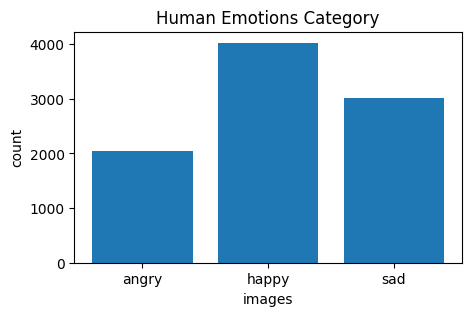

In [50]:
plt.figure(figsize=(5,3))
plt.bar(classes,np.add(no_train_images,no_test_images))
plt.xlabel('images')
plt.ylabel('count')
plt.title('Human Emotions Category')
plt.show()

In [51]:
print("angry images contribution :{} %".format(np.round(np.add(no_train_images,no_test_images)[0]/np.sum(np.add(no_train_images,no_test_images)),3)*100))
print("happy images contribution :{} %".format(np.round(np.add(no_train_images,no_test_images)[1]/np.sum(np.add(no_train_images,no_test_images)),3)*100))
print("sad   images contribution :{} %".format(np.round(np.add(no_train_images,no_test_images)[2]/np.sum(np.add(no_train_images,no_test_images)),3)*100))

angry images contribution :22.5 %
happy images contribution :44.3 %
sad   images contribution :33.2 %


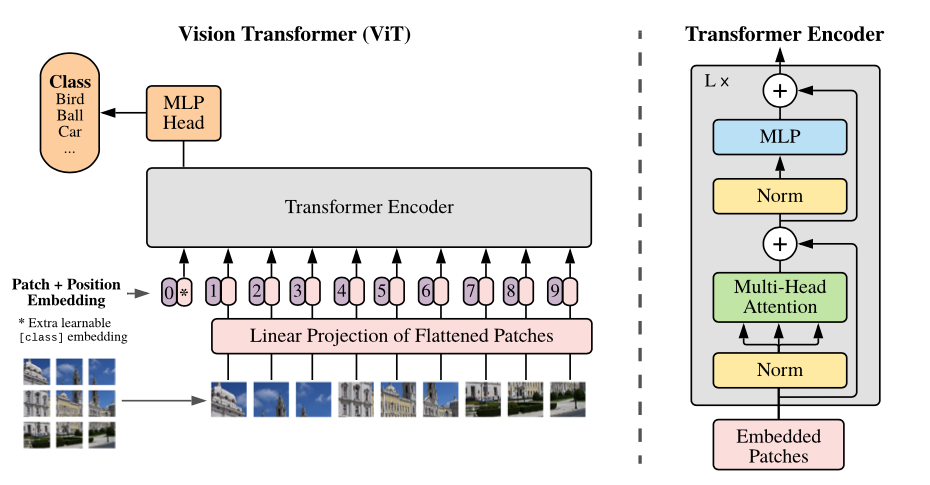

In [52]:
from PIL import Image
from IPython.display import display
img = Image. open('C:\\ajay_ml\\VIT_Transformers\\VIT_Architecture_1.png')
display(img)

### Patch Encoder class

In [53]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self,N_PATCHES=256,HIDDEN_SIZE=768):
        super(PatchEncoder,self).__init__()
        self.N_PATCHES = N_PATCHES
        self.HIDDEN_SIZE = HIDDEN_SIZE

        # Initialize Dense layer which acts a project layer output -> x768
        self.linear_projection = keras.layers.Dense(units=self.HIDDEN_SIZE)
        
        # Embedding layers 2D input [Batch_size, input_dim], 3D output [batch,input_dim,output] ex : None*256*768
        self.positional_embedding = keras.layers.Embedding(input_dim=self.N_PATCHES,output_dim=self.HIDDEN_SIZE)

    # define forward feed
    def call(self,image):

        patches = tf.image.extract_patches(images=image,sizes=[1,16,16,1],strides=[1,16,16,1],rates=[1,1,1,1],padding="VALID")
        patches = tf.reshape(patches,(1,patches.shape[1]*patches.shape[2],patches.shape[-1]))

        # patches to linear projects
        x = self.linear_projection(patches)

        # define positional embedding
        embedding_input = tf.range(0,256,1)
        positional_embedding =self.positional_embedding(embedding_input)

        # add linear projection with positional embedding
        output = x + positional_embedding
        return output

In [54]:
patchEnc = PatchEncoder()
pEnc = patchEnc(tf.zeros([1,256,256,3]))
print(pEnc.shape)

(1, 256, 768)


### Transformer Encoder class

In [55]:
class TransformerEncoder(keras.layers.Layer):
    def __init__(self,N_HEADS=8,HIDDEN_SIZE=768):
        super(TransformerEncoder,self).__init__()
        self.N_HEADS = N_HEADS
        self.HIDDEN_SIZE = HIDDEN_SIZE

        # Transformer Encoder contains 2-Normalization 1-MultiAttention 2-MLP Dense layers
        self.norm1 = keras.layers.LayerNormalization(name="Transofrmer_encoder_norm_1")
        self.norm2 = keras.layers.LayerNormalization(name="Transofrmer_encoder_norm_2")
        self.multi_head_attention = keras.layers.MultiHeadAttention(num_heads=self.N_HEADS, key_dim=self.HIDDEN_SIZE,name="multi_head_attention")
        self.dense1 = keras.layers.Dense(units=self.HIDDEN_SIZE,activation=tf.nn.gelu,name="Transofrmer_encoder_dense1")
        self.dense2 = keras.layers.Dense(units=self.HIDDEN_SIZE,activation=tf.nn.gelu,name="Transofrmer_encoder_dense2")

    # feed forward n/w as per transformer embedding
    def call(self,inputs):
        x1 = self.norm1(inputs)
        x1 = self.multi_head_attention(x1,x1)
        x1 = keras.layers.Add()([x1,inputs])

        x2 = self.norm2(x1)
        x2 = self.dense1(x2)
        x2 = self.dense2(x2)

        output = keras.layers.Add()([x2,x1])

        return output

In [56]:
N_HEADS=8
HIDDEN_SIZE=768
transformerEnc = TransformerEncoder(N_HEADS,HIDDEN_SIZE)
transformerEnc(pEnc)

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[ 0.4233436 , -0.09312204,  0.28853083, ...,  0.05361234,
          0.08856772,  0.32751074],
        [-0.12230425, -0.13173445, -0.12741625, ..., -0.16335152,
         -0.15387791,  0.20335124],
        [-0.190653  , -0.14697993, -0.00777359, ...,  0.3935747 ,
         -0.13446106, -0.15125799],
        ...,
        [-0.06738663, -0.15444003,  0.03138157, ...,  0.61887395,
         -0.02309765,  0.6078574 ],
        [-0.16452038, -0.065439  ,  0.46453407, ..., -0.17503044,
         -0.14596558,  0.36842263],
        [-0.09221002, -0.14292881,  0.05314263, ..., -0.02311567,
          0.17956677,  0.24418402]]], dtype=float32)>

### Visual Transformer class

In [57]:
# Create Visual Transformer class by using Patch Encoder,Transformer Encoder & define final MLP layers
class VITModel(keras.models.Model):
    def __init__(self,N_HEADS=8,N_PATCHES=256,HIDDEN_SIZE=768,N_LAYERS=12,NUM_DENSE_UNITS=3):
        super(VITModel,self).__init__()
        self.N_HEADS=N_HEADS
        self.N_PATCHES = N_PATCHES
        self.HIDDEN_SIZE = HIDDEN_SIZE
        self.N_LAYERS = N_LAYERS
        self.NUM_DENSE_UNITS = NUM_DENSE_UNITS

        self.patchencoder = PatchEncoder(self.N_PATCHES,self.HIDDEN_SIZE)
        self.transformerencoder = [TransformerEncoder(self.N_HEADS,self.HIDDEN_SIZE)for i in range(self.N_LAYERS)]

        self.dense_1 = Dense(2,activation=tf.nn.gelu)
        self.dense_2 = Dense(2,activation=tf.nn.gelu)
        self.flatten1 = Flatten()
        self.dense = Dense(units=self.NUM_DENSE_UNITS,activation="softmax")

    def call(self,inputs):
        x = self.patchencoder(inputs)
        for i in range(self.N_LAYERS):
            x = self.transformerencoder[i](x)

        x = self.flatten1(x)  
        x = self.dense_1(x)
        x = self.dense_2(x)
        output = self.dense(x)
        return output  

### Fit data to VITModel

In [58]:
# VIT model instance and configure compiler , loss function and metrics

In [59]:
vit = VITModel(N_HEADS=8,N_PATCHES=256,HIDDEN_SIZE=768,N_LAYERS=2,NUM_DENSE_UNITS=3)
res=vit(tf.zeros([1,256,256,3]))

In [60]:
vit.compile(optimizer="adam",loss=keras.losses.categorical_crossentropy,metrics=[keras.metrics.categorical_accuracy])

In [61]:
# Train the model

In [64]:
history=vit.fit(train_dataset,epochs=2,validation_data=(validation_dataset),batch_size=32)

Epoch 1/2
6799/6799 [==============================] - 126s 18ms/step - loss: 1.0627 - categorical_accuracy: 0.4440 - val_loss: 1.0633 - val_categorical_accuracy: 0.4416
Epoch 2/2
6799/6799 [==============================] - 126s 19ms/step - loss: 1.0626 - categorical_accuracy: 0.4440 - val_loss: 1.0633 - val_categorical_accuracy: 0.4416
